# Improving Employee Retention by Predicting Employee Attrition Using Machine Learning

## Overview

<p align='justify'> "Sumber daya manusia (SDM) adalah aset utama yang perlu dikelola dengan baik oleh perusahaan agar tujuan bisnis dapat tercapai dengan efektif dan efisien. Pada kesempatan kali ini, kita akan menghadapi sebuah permasalahan tentang sumber daya manusia yang ada di perusahaan. Fokus kita adalah untuk mengetahui bagaimana cara menjaga karyawan agar tetap bertahan di perusahaan yang ada saat ini yang dapat mengakibatkan bengkaknya biaya untuk rekrutmen karyawan serta pelatihan untuk mereka yang baru masuk. Dengan mengetahui faktor utama yang menyebabkan karyawan tidak merasa, perusahaan dapat segera menanggulanginya dengan membuat program-program yang relevan dengan permasalahan karyawan."</p>


## Import Relevant Packages

In [ ]:
!pip install xgboost
!pip install lightgbm
!pip install shap

In [ ]:
#data wrangling
import numpy as np
import pandas as pd

#data viz
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warning
import warnings
warnings.filterwarnings('ignore')

#pandas customize setting
pd.set_option("display.max_columns", 30)
pd.set_option("display.max_rows", 25)
pd.set_option("display.max_colwidth", 100)

#data prepration
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler,OneHotEncoder, OrdinalEncoder

#modelling
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier
import lightgbm as lgb

#evaluate
from sklearn.metrics import classification_report, accuracy_score, recall_score, precision_score, f1_score, roc_auc_score, confusion_matrix, roc_curve


## Load Dataset

In [ ]:
try:
  df = pd.read_excel('Improving Employee Retention by Predicting Employee Attrition Using Machine Learning.xlsx')
except:
  !gdown 1EQlE-TUc06O1-HBRP-siI3ZV_4g48-68
  df = pd.read_excel('Improving Employee Retention by Predicting Employee Attrition Using Machine Learning.xlsx')

## Data Understanding

In [ ]:
df.sample(5)

In [ ]:
print('Jumlah Data :', df.shape[0])
print('Jumlah Kolom : ', df.shape[1])

**First Impression**
- Sekilas terlihat 1 username mewakili satu employee
- Enterprise id adalah primary key atau identifier satu employee
- Feature terdiri dari kategorikal, numerikal dan juga datetime
- Terdapat missing value pada beberapa kolom
- Kolom AlasanResign atau Tanggal Resign dapat dijadikan target


### Check Dataframe Info

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 25 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   Username                            287 non-null    object 
 1   EnterpriseID                        287 non-null    int64  
 2   StatusPernikahan                    287 non-null    object 
 3   JenisKelamin                        287 non-null    object 
 4   StatusKepegawaian                   287 non-null    object 
 5   Pekerjaan                           287 non-null    object 
 6   JenjangKarir                        287 non-null    object 
 7   PerformancePegawai                  287 non-null    object 
 8   AsalDaerah                          287 non-null    object 
 9   HiringPlatform                      287 non-null    object 
 10  SkorSurveyEngagement                287 non-null    int64  
 11  SkorKepuasanPegawai                 282 non-n

**Analisa Output**
- Hampir 90% data pada kolom IkutProgramOp adalah missingvalue, sehingga harus di drop
- Kolom SkorKepuasanPegawai, JumlahKeikutsertaanProjek, JumlahKeterlambatanSebulanTerakhir, JumlahKetidakhadiran, AlasanResign memiliki data yang missing value yang bisa ditoleransi oleh sebab itu perlu dilakukan imputasi.
- Untuk kolom tanggal dapat dilakukan casting tipe data menjadi datetime
- Untuk kolom nomorHP dan email dapat dilakukan feature extraction seperti provider
- PerformancePegawai, tingkatPendidikan dapat di casting menjadi numerikal      

### Check Missing Value

In [ ]:
round((df.isnull().sum()/df.shape[0])*100,2)

Username                               0.00
EnterpriseID                           0.00
StatusPernikahan                       0.00
JenisKelamin                           0.00
StatusKepegawaian                      0.00
Pekerjaan                              0.00
JenjangKarir                           0.00
PerformancePegawai                     0.00
AsalDaerah                             0.00
HiringPlatform                         0.00
SkorSurveyEngagement                   0.00
SkorKepuasanPegawai                    1.74
JumlahKeikutsertaanProjek              1.05
JumlahKeterlambatanSebulanTerakhir     0.35
JumlahKetidakhadiran                   2.09
NomorHP                                0.00
Email                                  0.00
TingkatPendidikan                      0.00
PernahBekerja                          0.00
IkutProgramLOP                        89.90
AlasanResign                          23.00
TanggalLahir                           0.00
TanggalHiring                   

**Analisa Output**
- Missing value '<30' % masih bisa di tolerir dengan dilakukan imputasi
- missing value hampir 90% lebih baik di drop saja

### Check Duplicate Data

In [ ]:
df.duplicated().sum()

0

In [ ]:
df.duplicated(subset=['Username']).sum()

2

In [ ]:
df.duplicated(subset=['EnterpriseID']).sum()

0

In [ ]:
df[df.duplicated(subset=['Username'], keep=False)][['Username','Email','TanggalLahir']]

,Username,Email,TanggalLahir
80,brainyMagpie7,brainyMagpie7048@gmail.com,1986-09-01
120,brainyMagpie7,brainyMagpie7608@proton.com,1970-04-25
158,boredEggs0,boredEggs0834@outlook.com,1974-01-12
204,boredEggs0,boredEggs0225@outlook.com,1967-06-03


In [ ]:
df[['Username','Email','TanggalLahir']].head()

,Username,Email,TanggalLahir
0,spiritedPorpoise3,spiritedPorpoise3135@yahoo.com,1972-07-01
1,jealousGelding2,jealousGelding2239@yahoo.com,1984-04-26
2,pluckyMuesli3,pluckyMuesli3961@icloud.com,1974-01-07
3,stressedTruffle1,stressedTruffle1406@hotmail.com,1979-11-24
4,shyTermite7,shyTermite7149@gmail.com,1974-11-07


**Analisa Output**
- Bila dilihat dari username terdapat dua data yang duplikat
- tetapi bila kita lihat lebih detail lagi, kemungkinan terjadi kesalahan extract data
- dapat disimpulkan bahwa tidak ada data yang duplikat 

### Check Unique Value

In [ ]:
value_list = []

for i in df.columns:
    dtype = df[i].dtype
    unique = df[i].nunique()
    unique_sample = df[i].unique()[:5]
    value_counts = [x for x in round((df[i].value_counts()/df[i].value_counts().sum()*100),2)][:5]
    
    value_list.append([dtype, unique, unique_sample, value_counts])

df_desc = pd.DataFrame(value_list, index=df.columns, columns = ['Tipe_Data', 'Nunique', 'Unique_Sample', 'Value_Pct']).sort_values(by='Nunique', ascending=False)
df_desc

,Tipe_Data,Nunique,Unique_Sample,Value_Pct
EnterpriseID,int64,287,"[111065, 106080, 106452, 106325, 111171]","[0.35, 0.35, 0.35, 0.35, 0.35]"
Email,object,287,"[spiritedPorpoise3135@yahoo.com, jealousGelding2239@yahoo.com, pluckyMuesli3961@icloud.com, stre...","[0.35, 0.35, 0.35, 0.35, 0.35]"
NomorHP,object,287,"[+6282232522xxx, +6281270745xxx, +6281346215xxx, +6283233846xxx, +6287883263xxx]","[0.35, 0.35, 0.35, 0.35, 0.35]"
Username,object,285,"[spiritedPorpoise3, jealousGelding2, pluckyMuesli3, stressedTruffle1, shyTermite7]","[0.7, 0.7, 0.35, 0.35, 0.35]"
TanggalLahir,object,284,"[1972-07-01, 1984-04-26, 1974-01-07, 1979-11-24, 1974-11-07]","[0.7, 0.7, 0.7, 0.35, 0.35]"
TanggalPenilaianKaryawan,object,127,"[2016-2-15, 2020-1-17, 2016-01-10, 2020-02-04, 2020-1-22]","[5.92, 4.18, 3.48, 3.14, 3.14]"
TanggalHiring,object,97,"[2011-01-10, 2014-01-06, 2014-2-17, 2013-11-11, 2016-10-02]","[4.18, 3.83, 3.14, 3.14, 3.14]"
TanggalResign,object,53,"[-, 2018-6-16, 2014-9-24, 2018-09-06, 2019-01-12]","[68.99, 3.14, 3.14, 3.14, 3.14]"
JumlahKetidakhadiran,float64,22,"[9.0, 3.0, 11.0, 6.0, 10.0]","[7.12, 7.12, 6.76, 6.05, 6.05]"
Pekerjaan,object,14,"[Software Engineer (Back End), Data Analyst, Software Engineer (Front End), Product Manager, Sof...","[37.98, 25.09, 8.36, 8.36, 5.92]"


In [ ]:
df['AlasanResign'].value_counts()

masih_bekerja               132
jam_kerja                    16
ganti_karir                  14
kejelasan_karir              11
tidak_bisa_remote            11
toxic_culture                10
leadership                    9
tidak_bahagia                 8
internal_conflict             4
Product Design (UI & UX)      4
apresiasi                     2
Name: AlasanResign, dtype: int64

In [ ]:
df['HiringPlatform'].value_counts()

Indeed                     85
LinkedIn                   69
Google_Search              46
Diversity_Job_Fair         27
Employee_Referral          24
CareerBuilder              22
Website                    11
Other                       2
On-line_Web_application     1
Name: HiringPlatform, dtype: int64

**Analisa Output**
- Kolom EnterpriseID dan Username adalah identifier, sebelum pemodelan kolom ini baiknya di drop.
- Kolom email dan no hp bisa di extract,
- dapat dilakukan feature engineering seperti lama bekerja, usia
- kolom pernahBekerja terdiri dari satu nilai unique, sehingga di drop saja
- terdapat typo pada kolom StatusPernikahan sehingga nilai '-' perlu di replace menjadi Lainnya
- terdapat sepertinya salah input pada kolom AlasanResign yaitu Product Design (UI & UX), sehingga perlu di replace ke nilai mode
- Asal Daerah terlihat semuanya berasal dari DKI Jakarta

## Data Preprocessing

### Handle Missing Value

In [ ]:
# SkorKepuasanPegawai, JumlahKeikutsertaanProjek, JumlahKeterlambatanSebulanTerakhir, JumlahKetidakhadiran, AlasanResign
df['JumlahKetidakhadiran'].median()

10.0

In [ ]:
#inputasi median untuk numerikal feature

df['SkorKepuasanPegawai'].fillna(df['SkorKepuasanPegawai'].median(), inplace=True, downcast='infer')
df['JumlahKeikutsertaanProjek'].fillna(df['JumlahKeikutsertaanProjek'].median(), inplace=True, downcast='infer')
df['JumlahKeterlambatanSebulanTerakhir'].fillna(df['JumlahKeterlambatanSebulanTerakhir'].median(), inplace=True, downcast='infer')
df['JumlahKetidakhadiran'].fillna(df['JumlahKetidakhadiran'].median(), inplace=True, downcast='infer')

In [ ]:
#inputasi mode untuk kategorikal feature
df['AlasanResign'].fillna(df['AlasanResign'].mode()[0], inplace=True)

In [ ]:
#check null lagi
df.isnull().sum()

Username                                0
EnterpriseID                            0
StatusPernikahan                        0
JenisKelamin                            0
StatusKepegawaian                       0
Pekerjaan                               0
JenjangKarir                            0
PerformancePegawai                      0
AsalDaerah                              0
HiringPlatform                          0
SkorSurveyEngagement                    0
SkorKepuasanPegawai                     0
JumlahKeikutsertaanProjek               0
JumlahKeterlambatanSebulanTerakhir      0
JumlahKetidakhadiran                    0
NomorHP                                 0
Email                                   0
TingkatPendidikan                       0
PernahBekerja                           0
IkutProgramLOP                        258
AlasanResign                            0
TanggalLahir                            0
TanggalHiring                           0
TanggalPenilaianKaryawan          

### Replace Unvalid value

In [ ]:
#ganti typo
df['StatusPernikahan'].replace({'-':df['StatusPernikahan'].mode()[0]}, inplace=True)

In [ ]:
df['StatusPernikahan'].value_counts()

Belum_menikah    135
Menikah           57
Lainnya           48
Bercerai          47
Name: StatusPernikahan, dtype: int64

In [ ]:
df['AlasanResign'].value_counts()

masih_bekerja               198
jam_kerja                    16
ganti_karir                  14
kejelasan_karir              11
tidak_bisa_remote            11
toxic_culture                10
leadership                    9
tidak_bahagia                 8
internal_conflict             4
Product Design (UI & UX)      4
apresiasi                     2
Name: AlasanResign, dtype: int64

In [ ]:
df[df['AlasanResign'] == 'Product Design (UI & UX)']

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
27,pluckyApples4,110566,Menikah,Wanita,FullTime,Software Engineer (Front End),Senior_level,Biasa,Jakarta Selatan,LinkedIn,3,5,0,0,15,+6281988935xxx,pluckyApples4880@icloud.com,Sarjana,1,NaN,Product Design (UI & UX),1987-04-10,2016-07-06,2020-1-28,2016-08-07
124,dearKitten3,111266,Belum_menikah,Pria,FullTime,Product Design (UI & UX),Freshgraduate_program,Sangat_bagus,Jakarta Utara,Diversity_Job_Fair,3,3,0,0,19,+6289679074xxx,dearKitten3235@yahoo.com,Sarjana,1,NaN,Product Design (UI & UX),1989-05-02,2011-9-26,2014-03-02,2017-12-15
147,brainyLlama9,100884,Menikah,Wanita,FullTime,Software Engineer (Front End),Freshgraduate_program,Sangat_bagus,Jakarta Timur,LinkedIn,3,5,0,0,20,+6285503547xxx,brainyLlama9557@gmail.com,Sarjana,1,NaN,Product Design (UI & UX),1969-02-09,2012-03-07,2014-02-01,2016-4-24
203,hushedBobolink8,106392,Menikah,Wanita,FullTime,Software Engineer (Back End),Mid_level,Sangat_bagus,Jakarta Selatan,Website,3,5,0,0,9,+6285522082xxx,hushedBobolink8263@outlook.com,Sarjana,1,NaN,Product Design (UI & UX),1988-08-29,2012-01-09,2020-02-01,2018-04-01


In [ ]:
#ganti kesalahan inputasi
#karena semua datanya resign
# alasan sepertinya 'tidak_disebutkan' 
df['AlasanResign'].replace({'Product Design (UI & UX)':'tidak_disebutkan'}, inplace=True)
df['AlasanResign'].value_counts()

masih_bekerja        198
jam_kerja             16
ganti_karir           14
kejelasan_karir       11
tidak_bisa_remote     11
toxic_culture         10
leadership             9
tidak_bahagia          8
internal_conflict      4
tidak_disebutkan       4
apresiasi              2
Name: AlasanResign, dtype: int64

In [ ]:
#ganti - menjadi nan
df['TanggalResign'].replace({'-':np.nan}, inplace=True)

### Feature Extraction

In [ ]:
#ambil email provider
df['EmailProvider'] = df['Email'].apply(lambda x: x.split('@')[-1]).str.replace('.com','')

In [ ]:
#ambil phone provider
df['PhoneProvider'] = str(0) + df['NomorHP'].apply(lambda x:x[3:6])

In [ ]:
#ambil kolom yang mengandung tanggal
to_dt = []
for x in df.columns.to_list():
  if 'Tanggal' in x:
    to_dt.append(x)

In [ ]:
#casting kolom tanggal ke datetime
for x in to_dt:
  df[x] = pd.to_datetime(df[x])

In [ ]:
df[to_dt]

,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
0,1972-07-01,2011-01-10,2016-02-15,NaT
1,1984-04-26,2014-01-06,2020-01-17,2018-06-16
2,1974-01-07,2011-01-10,2016-01-10,2014-09-24
3,1979-11-24,2014-02-17,2020-02-04,NaT
4,1974-11-07,2013-11-11,2020-01-22,2018-09-06
...,...,...,...,...
282,1973-12-08,2011-09-26,2016-03-01,NaT
283,1974-12-01,2013-05-13,2020-01-28,2017-11-15
284,1969-10-30,2013-11-11,2020-01-21,2018-06-08
285,1981-10-01,2011-05-16,2014-04-05,2018-04-01


In [ ]:
df[to_dt].describe()

,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign
count,287,287,287,89
unique,284,97,127,52
top,1987-06-14 00:00:00,2011-01-10 00:00:00,2020-01-14 00:00:00,2017-11-15 00:00:00
freq,2,12,17,9
first,1951-01-02 00:00:00,2006-01-09 00:00:00,2011-07-14 00:00:00,2013-05-30 00:00:00
last,1992-08-17 00:00:00,2018-07-09 00:00:00,2020-02-28 00:00:00,2020-09-27 00:00:00


In [ ]:
#feature engineering lama bekerja
df['LamaBekerja'] = df['TanggalResign'].dt.year - df['TanggalHiring'].dt.year

In [ ]:
df['LamaBekerja'].value_counts()

 5.0    13
 7.0    12
 6.0    12
 3.0    11
 1.0    10
 4.0     9
 0.0     9
 2.0     5
 8.0     4
 9.0     2
-1.0     1
-4.0     1
Name: LamaBekerja, dtype: int64

In [ ]:
df[df['LamaBekerja']<0]

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign,EmailProvider,PhoneProvider,LamaBekerja
108,jealousIguana3,111209,Belum_menikah,Wanita,FullTime,Data Analyst,Freshgraduate_program,Biasa,Jakarta Timur,CareerBuilder,4,4,0,0,10,+6283373813xxx,jealousIguana3026@gmail.com,Sarjana,1,0.0,toxic_culture,1976-09-22,2015-03-30,2020-01-21,2014-08-19,gmail,0833,-1.0
207,troubledQuiche5,106480,Menikah,Wanita,FullTime,Software Engineer (Front End),Mid_level,Sangat_bagus,Jakarta Pusat,Indeed,4,3,5,0,17,+6285896075xxx,troubledQuiche5924@icloud.com,Sarjana,1,NaN,leadership,1972-11-21,2017-01-07,2020-02-06,2013-05-30,icloud,0858,-4.0


In [ ]:
#swap 

temp_a = df['TanggalResign'].loc[[108,207]]
temp_b = df['TanggalHiring'].loc[[108,207]]

df['TanggalResign'].loc[[108,207]] = temp_b
df['TanggalHiring'].loc[[108,207]] = temp_a

In [ ]:
df['LamaBekerja'] = np.absolute(df['LamaBekerja'])

In [ ]:
df.iloc[[108,207]]

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,NomorHP,Email,TingkatPendidikan,PernahBekerja,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign,EmailProvider,PhoneProvider,LamaBekerja
108,jealousIguana3,111209,Belum_menikah,Wanita,FullTime,Data Analyst,Freshgraduate_program,Biasa,Jakarta Timur,CareerBuilder,4,4,0,0,10,+6283373813xxx,jealousIguana3026@gmail.com,Sarjana,1,0.0,toxic_culture,1976-09-22,2014-08-19,2020-01-21,2015-03-30,gmail,0833,1.0
207,troubledQuiche5,106480,Menikah,Wanita,FullTime,Software Engineer (Front End),Mid_level,Sangat_bagus,Jakarta Pusat,Indeed,4,3,5,0,17,+6285896075xxx,troubledQuiche5924@icloud.com,Sarjana,1,NaN,leadership,1972-11-21,2013-05-30,2020-02-06,2017-01-07,icloud,0858,4.0


In [ ]:
for x in df[df['LamaBekerja'].isnull()].index:
  df['LamaBekerja'].loc[x] = 2020 - df['TanggalHiring'].dt.year.loc[x]

In [ ]:
#ambil tahun
df['TahunHiring']= df['TanggalHiring'].dt.year
df['TahunResign'] = df['TanggalResign'].dt.year

In [ ]:
#feature engineering usia awal bekerja
df['UsiaAwalBekerja'] = df['TanggalHiring'].dt.year - df['TanggalLahir'].dt.year

In [ ]:
#asumsikan tahun di data adalah 2020
df['UsiaSaatIni'] = 2020 - df['TanggalLahir'].dt.year

In [ ]:
#resign sebelum penilaian?
df['ResignSebelumPenilaian'] = (df['TanggalResign'] - df['TanggalPenilaianKaryawan']).dt.days

def ResignSebelumPenilaian(x):
  if x > 0:
    result = 1
  elif x < 0 :
    result = 0
  else:
    result = np.nan
  
  return result

df['ResignSebelumPenilaian'] = df['ResignSebelumPenilaian'].apply(lambda x: ResignSebelumPenilaian(x))

In [ ]:
#feature is resign

df['IsResign'] = np.where(df['TanggalResign'].isnull(), 0, 1)

In [ ]:
df.sample(5)

,Username,EnterpriseID,StatusPernikahan,JenisKelamin,StatusKepegawaian,Pekerjaan,JenjangKarir,PerformancePegawai,AsalDaerah,HiringPlatform,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,...,IkutProgramLOP,AlasanResign,TanggalLahir,TanggalHiring,TanggalPenilaianKaryawan,TanggalResign,EmailProvider,PhoneProvider,LamaBekerja,TahunHiring,TahunResign,UsiaAwalBekerja,UsiaSaatIni,ResignSebelumPenilaian,IsResign
44,shySyrup7,105543,Belum_menikah,Pria,FullTime,Software Engineer (Front End),Freshgraduate_program,Bagus,Jakarta Barat,LinkedIn,1,3,0,5,16,...,NaN,masih_bekerja,1979-08-12,2011-07-11,2017-05-01,NaT,yahoo,0812,9.0,2011,NaN,32,41,NaN,0
183,aboardUnicorn8,106687,Belum_menikah,Pria,FullTime,Software Engineer (Back End),Mid_level,Bagus,Jakarta Timur,Indeed,3,3,0,0,6,...,NaN,masih_bekerja,1968-01-15,2006-01-09,2020-01-04,NaT,outlook,0819,14.0,2006,NaN,38,52,NaN,0
52,crummyPudding5,100826,Lainnya,Wanita,Outsource,Software Engineer (Back End),Freshgraduate_program,Biasa,Jakarta Utara,Indeed,3,5,0,0,7,...,NaN,masih_bekerja,1992-06-18,2013-11-11,2020-02-18,NaT,icloud,0898,7.0,2013,NaN,21,28,NaN,0
117,contentAbalone0,101331,Belum_menikah,Wanita,Outsource,Software Engineer (Front End),Freshgraduate_program,Biasa,Jakarta Pusat,Google_Search,4,4,0,0,7,...,0.0,masih_bekerja,1979-05-01,2011-02-07,2014-03-04,NaT,icloud,0822,9.0,2011,NaN,32,41,NaN,0
149,pridefulBuck8,106483,Lainnya,Wanita,Outsource,Software Engineer (Android),Mid_level,Bagus,Jakarta Utara,Website,4,4,0,0,8,...,NaN,masih_bekerja,1974-12-05,2014-01-06,2020-01-31,NaT,icloud,0899,6.0,2014,NaN,40,46,NaN,0


### Drop Unnecessary Feature

Adapun beberapa feature yang tidak bisa digunakan
- Terlalu banyak nilai unique
  1. Username
  2. EnterpriseID
  3. NomorHP
  4. Email
- Terlalu banyak missing value
  1. IkutProgramLOP
- Memiliki Satu unik value
  1. PernahBekerja

In [ ]:
drop_feature = ['Username', 'EnterpriseID', 'NomorHP','Email', 'IkutProgramLOP','PernahBekerja']

df.drop(drop_feature, axis=1, inplace=True)

## Bussiness Insight

### Annual Report on Employee Number Changes

Setiap tahunnya perusahaan menyadari ada yang keluar dan ada yang masuk (karyawan), namun apabila pada tahun tertentu jumlah karyawan yang keluar lebih banyak dari yang masuk artinya perusahaan perlu berbenah diri agar karyawan lain tetap bertahan sehingga rancangan strategi jangka panjang tetap dapat dilaksanakan tanpa kendala.

In [ ]:
# Membuat dua tabel agregat yang menghitung jumlah karyawan yang masuk dan keluar berdasarkan tahun

employe_hire_by_year = df.groupby(['TahunHiring']).agg({'IsResign':'count'}).reset_index().rename({'TahunHiring':'Tahun','IsResign':'Total Hire'}, axis=1)
employe_resign_by_year = df.groupby(['TahunResign']).agg({'IsResign':'count'}).reset_index().astype('int').rename({'TahunResign':'Tahun','IsResign':'Total Resign'}, axis=1)

In [ ]:
employe_hire_by_year

,Tahun,Total Hire
0,2006,1
1,2007,2
2,2008,2
3,2009,7
4,2010,8
5,2011,76
6,2012,41
7,2013,44
8,2014,57
9,2015,30


In [ ]:
employe_resign_by_year

,Tahun,Total Resign
0,2013,4
1,2014,11
2,2015,9
3,2016,8
4,2017,20
5,2018,26
6,2019,5
7,2020,6


In [ ]:
employe_by_year = pd.merge(employe_hire_by_year, employe_resign_by_year, on='Tahun', how='outer').fillna(0).astype('int')
employe_by_year

,Tahun,Total Hire,Total Resign
0,2006,1,0
1,2007,2,0
2,2008,2,0
3,2009,7,0
4,2010,8,0
5,2011,76,0
6,2012,41,0
7,2013,44,4
8,2014,57,11
9,2015,30,9


In [ ]:
# hitung total karyawan
# menggunakan cumsum()

employe_by_year['Total Employee'] = np.cumsum(employe_by_year['Total Hire'] - employe_by_year['Total Resign'])

In [ ]:
# trafik masuk vs keluar(perubahan)
# total karyawan yang ada - total karyawan yang resign di setiap tahunnya

employe_by_year['Trafik'] = employe_by_year['Total Hire'] - employe_by_year['Total Resign']

In [ ]:
employe_by_year

,Tahun,Total Hire,Total Resign,Total Employee,Trafik
0,2006,1,0,1,1
1,2007,2,0,3,2
2,2008,2,0,5,2
3,2009,7,0,12,7
4,2010,8,0,20,8
5,2011,76,0,96,76
6,2012,41,0,137,41
7,2013,44,4,177,40
8,2014,57,11,223,46
9,2015,30,9,244,21


In [ ]:
import plotly.graph_objects as go

In [ ]:
total = employe_by_year['Total Hire'].sum() - employe_by_year['Total Resign'].sum()

measure = ['relative']*len(employe_by_year) + ['total']
x = [str(x) for x in employe_by_year['Tahun']] + ['Total']
text = ['+'+str(x) if x > 0 else str(x) for x in employe_by_year['Trafik']]+[str(total)]
y = employe_by_year['Trafik'].tolist() + [str(total)]

fig = go.Figure(go.Waterfall(
    name = '20', orientation = 'v',
    measure = measure,
    x =x,
    textposition = 'outside',
    text = text,
    y = y,
    connector = {"line":{"color":"rgb(63, 63, 63)"}},
    )
)

fig.update_layout(
    title = "Employee Number Change by Year",
    showlegend = False,
    height = 600,
    width= 800,
    yaxis = dict(title = 'Total Employee'),
    xaxis = dict(title = 'Year')
)

fig.show()
    

**Analisa Output**

- Dari tahun 2006 - 2016 terlihat employee belum ada yang resign
- tahun 2011 adalah tahun terjadi perekrutan banyak employee
- terlihat dari tahun 2011-2015 kondisi perusahaan masih sehat
- Namun, pada tahun 2017-2020 terjadi penurunan employe sekitar 31%
- Kondisi tersebut meyebutkan bahwa perusahaan sedang tidak baik-baik saja
- Untuk itu perlu dilihat lagi apakah jumlah karyawan sesuai yang dibutuhkan atau adakah slot posisi kosong, sehingga pekerjaan terhambat dan menurunkan performa perusahaan?

### Resign Reason Analysis for Employee Attrition Management Strategy

Setelah mengetahui keadaan dari perusahaan yang sedang tidak baik-baik saja, langkah selanjutnya adalah mengetahui alasan pegawai untuk resign pada setiap divisi pekerjaan yang ada. Perusahaan ingin membuat strategi yang lebih personal sehingga setiap divisi pekerjaan yang ada diberikan perlakuan yang sesuai dengan keluhannya masing-masing. Hanya saja, perusahaan ingin mengetahui divisi apa yang paling rentan resign, kemudian langkah apa yang sekiranya bisa dilakukan oleh perusahaan. 

In [ ]:
# dataframe jumlah resign dan tidak resign berdasarkan pekerjaan
resign_by_job = df.query('IsResign == 1').groupby('Pekerjaan').agg({'IsResign':'count'}).reset_index().rename({'IsResign':'TotalResign'}, axis=1)
not_resign_by_job = df.query('IsResign == 0').groupby('Pekerjaan').agg({'IsResign':'count'}).reset_index().rename({'IsResign':'TotalEmployee'}, axis=1)

In [ ]:
resign_by_job

,Pekerjaan,TotalResign
0,Data Analyst,8
1,Data Engineer,3
2,Product Design (UI & UX),9
3,Product Manager,6
4,Software Engineer (Android),7
5,Software Engineer (Back End),28
6,Software Engineer (Front End),28


In [ ]:
not_resign_by_job

,Pekerjaan,TotalEmployee
0,Data Analyst,8
1,Data Engineer,7
2,DevOps Engineer,3
3,Digital Product Manager,2
4,Machine Learning Engineer,2
5,Product Design (UI & UX),15
6,Product Design (UX Researcher),1
7,Product Manager,11
8,Scrum Master,3
9,Software Architect,1


In [ ]:
# join dataframe
resign_df = pd.merge(resign_by_job, not_resign_by_job, on='Pekerjaan', how='outer').fillna(0).set_index('Pekerjaan').astype('int')

In [ ]:
resign_df

,TotalResign,TotalEmployee
Pekerjaan,,
Data Analyst,8,8
Data Engineer,3,7
Product Design (UI & UX),9,15
Product Manager,6,11
Software Engineer (Android),7,17
Software Engineer (Back End),28,81
Software Engineer (Front End),28,44
DevOps Engineer,0,3
Digital Product Manager,0,2


In [ ]:
#membuat kolom total employe
resign_df['Total'] = resign_df['TotalResign'] +  resign_df['TotalEmployee']

In [ ]:
resign_df

,TotalResign,TotalEmployee,Total
Pekerjaan,,,
Data Analyst,8,8,16
Data Engineer,3,7,10
Product Design (UI & UX),9,15,24
Product Manager,6,11,17
Software Engineer (Android),7,17,24
Software Engineer (Back End),28,81,109
Software Engineer (Front End),28,44,72
DevOps Engineer,0,3,3
Digital Product Manager,0,2,2


In [ ]:
#membuat kolom persentase
resign_df['TotalResign_Pct'] = (resign_df['TotalResign']/resign_df['Total'])*100
resign_df['TotalEmployee_Pct'] = (resign_df['TotalEmployee']/resign_df['Total'])*100

In [ ]:
resign_df

,TotalResign,TotalEmployee,Total,TotalResign_Pct,TotalEmployee_Pct
Pekerjaan,,,,,
Data Analyst,8,8,16,50.000000,50.000000
Data Engineer,3,7,10,30.000000,70.000000
Product Design (UI & UX),9,15,24,37.500000,62.500000
Product Manager,6,11,17,35.294118,64.705882
Software Engineer (Android),7,17,24,29.166667,70.833333
Software Engineer (Back End),28,81,109,25.688073,74.311927
Software Engineer (Front End),28,44,72,38.888889,61.111111
DevOps Engineer,0,3,3,0.000000,100.000000
Digital Product Manager,0,2,2,0.000000,100.000000


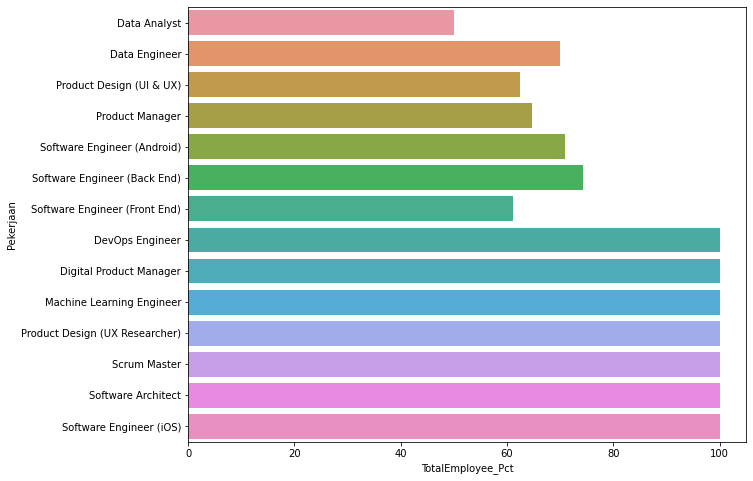

In [ ]:
plt.figure(figsize=(10,8))
sns.barplot(x=resign_df['TotalEmployee_Pct'], y=resign_df.index)
plt.show()

**Analisa Output**

Terlihat bahwa Data Analyst(50%) dan Front End paling banyak resign, untuk itu kita perlu melihat alasannya

#### Data Analyst

In [ ]:
da_resign = df.query('IsResign == 1 & Pekerjaan == "Data Analyst"').groupby(['JenjangKarir','PerformancePegawai','AlasanResign']).agg({'IsResign':'count'}).reset_index()
da_resign

,JenjangKarir,PerformancePegawai,AlasanResign,IsResign
0,Freshgraduate_program,Bagus,toxic_culture,1
1,Freshgraduate_program,Biasa,internal_conflict,1
2,Freshgraduate_program,Biasa,toxic_culture,1
3,Freshgraduate_program,Sangat_bagus,internal_conflict,1
4,Freshgraduate_program,Sangat_bagus,toxic_culture,3
5,Freshgraduate_program,Sangat_kurang,toxic_culture,1


In [ ]:
import plotly.express as px

fig = px.sunburst(da_resign, path=['JenjangKarir', 'PerformancePegawai', 'AlasanResign'], values='IsResign')
fig.update_layout(title_text='Jumlah Pegawai Data Analis yang Resign', title_x=0.5)

fig.show()

**Analisa Output**
- Terlihat Bahwa pengawai data analis adalah yang memiliki kinerja yang sangat bagus harus resign karena budaya perusahaan yang masih di dominasi toxic culture serta konflik internal

- Rekomendasi :
  - Perusahaan perlu berbenah diri dengan yang paling penting menerima segala masukan, kritikan dan saran
  - Mengidentifikasi Perilaku Toxic apa saja yang buat masalah
  - Perusahaan harus berbenah diri dengan tidak mentolerir toxic culture atau bahkan memecat pegawai yang punya toxic culture
  - HR dapat mempromosikan work-life balance
  - Mengajak karyawan untuk berdialog dan berdiskusi terbuka untuk mengatasi konflik internal

#### Front End

In [ ]:
fe_resign = df.query('IsResign == 1 & Pekerjaan == "Software Engineer (Front End)"').groupby(['JenjangKarir','PerformancePegawai','AlasanResign']).agg({'IsResign':'count'}).reset_index()
fe_resign

,JenjangKarir,PerformancePegawai,AlasanResign,IsResign
0,Freshgraduate_program,Bagus,jam_kerja,2
1,Freshgraduate_program,Bagus,tidak_bisa_remote,1
2,Freshgraduate_program,Biasa,apresiasi,1
3,Freshgraduate_program,Biasa,kejelasan_karir,1
4,Freshgraduate_program,Biasa,tidak_bisa_remote,1
5,Freshgraduate_program,Sangat_bagus,tidak_bisa_remote,3
6,Freshgraduate_program,Sangat_bagus,tidak_disebutkan,1
7,Freshgraduate_program,Sangat_kurang,kejelasan_karir,1
8,Mid_level,Bagus,leadership,1
9,Mid_level,Biasa,jam_kerja,1


In [ ]:
fig = px.sunburst(fe_resign, path=['JenjangKarir', 'PerformancePegawai', 'AlasanResign'], values='IsResign',
                 title= "Jumlah Pegawai Front End yang Resign")
fig.show()

Terlihat alasan front end resign sangat beragam

## EDA for Modelling

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 28 columns):
 #   Column                              Non-Null Count  Dtype         
---  ------                              --------------  -----         
 0   StatusPernikahan                    287 non-null    object        
 1   JenisKelamin                        287 non-null    object        
 2   StatusKepegawaian                   287 non-null    object        
 3   Pekerjaan                           287 non-null    object        
 4   JenjangKarir                        287 non-null    object        
 5   PerformancePegawai                  287 non-null    object        
 6   AsalDaerah                          287 non-null    object        
 7   HiringPlatform                      287 non-null    object        
 8   SkorSurveyEngagement                287 non-null    int64         
 9   SkorKepuasanPegawai                 287 non-null    int64         
 10  JumlahKeikutsertaanProjek 

### Univariate Analysis

#### Pemisahan Numerikal dan Kategorikal

In [ ]:
#separate numerical and categorical columns
num_var = df.select_dtypes(include=['float64', 'int64']).columns.to_list()
cat_var = df.select_dtypes(include=['object']).columns.to_list()

num_rem = ['IsResign','TahunHiring','TahunResign','UsiaAwalBekerja','ResignSebelumPenilaian']
cat_rem = ['EmailProvider','PhoneProvider']

for x in num_rem:
  num_var.remove(x)

for y in cat_rem:
  cat_var.remove(y)

In [ ]:
df[num_var].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 7 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   SkorSurveyEngagement                287 non-null    int64  
 1   SkorKepuasanPegawai                 287 non-null    int64  
 2   JumlahKeikutsertaanProjek           287 non-null    int64  
 3   JumlahKeterlambatanSebulanTerakhir  287 non-null    int64  
 4   JumlahKetidakhadiran                287 non-null    int64  
 5   LamaBekerja                         287 non-null    float64
 6   UsiaSaatIni                         287 non-null    int64  
dtypes: float64(1), int64(6)
memory usage: 15.8 KB


In [ ]:
df[cat_var].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 287 entries, 0 to 286
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   StatusPernikahan    287 non-null    object
 1   JenisKelamin        287 non-null    object
 2   StatusKepegawaian   287 non-null    object
 3   Pekerjaan           287 non-null    object
 4   JenjangKarir        287 non-null    object
 5   PerformancePegawai  287 non-null    object
 6   AsalDaerah          287 non-null    object
 7   HiringPlatform      287 non-null    object
 8   TingkatPendidikan   287 non-null    object
 9   AlasanResign        287 non-null    object
dtypes: object(10)
memory usage: 22.5+ KB


#### Numerikal Feature

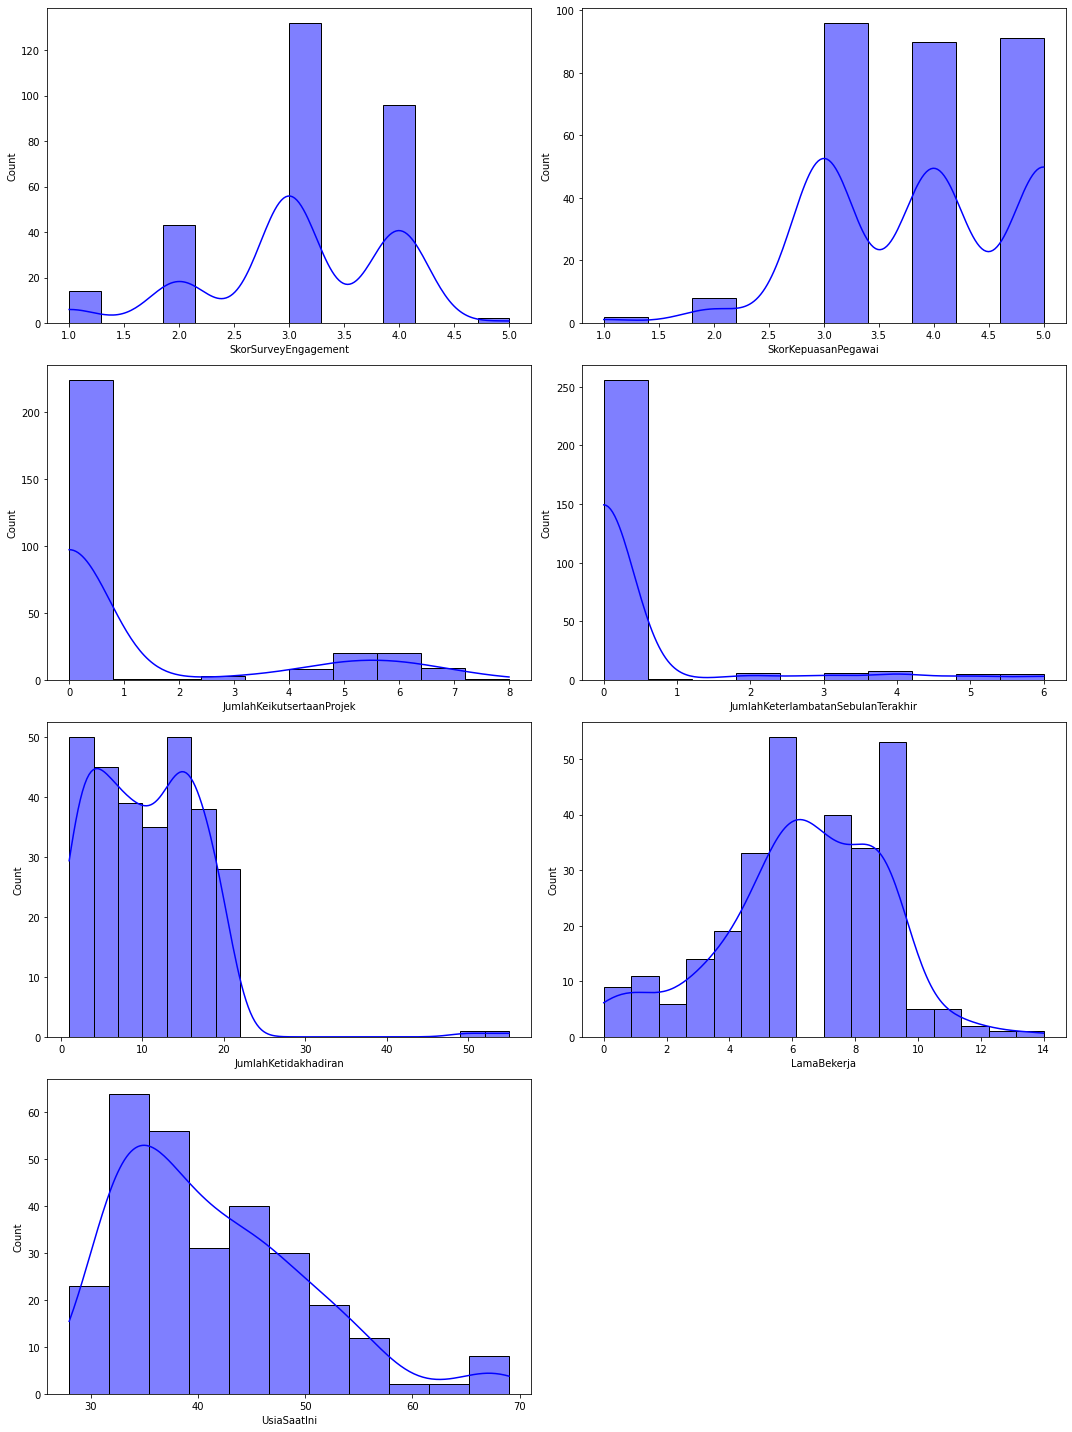

In [ ]:
plt.figure(figsize=(15, 20))
for i in range(0, len(num_var)):
    plt.subplot(4, 2, i+1)
    sns.histplot(df[num_var[i]], color='blue', kde=True)
    plt.tight_layout()

**Analisa Output**
- Terlihat data tidak ada yang berdistribusi Normal
- Sebagian besar pegawai memiliki skor engagement 3 dan 4
- terlihat kepuasan terhadap pegawai lumayan bagus dengan skor 3-5
- sebagian besar pegawai tidak mengikuti proyek
- pegawai dalam perusahaan ini adalah orang yang disiplin dilihat dengan jumlah keterlamatan 
- jumlah ketidakhadiran berada di antara 5-15 hari
- lama bekerja pegawai dari 5-9 tahun
- usia pegawai mayoritas 35 tahun 

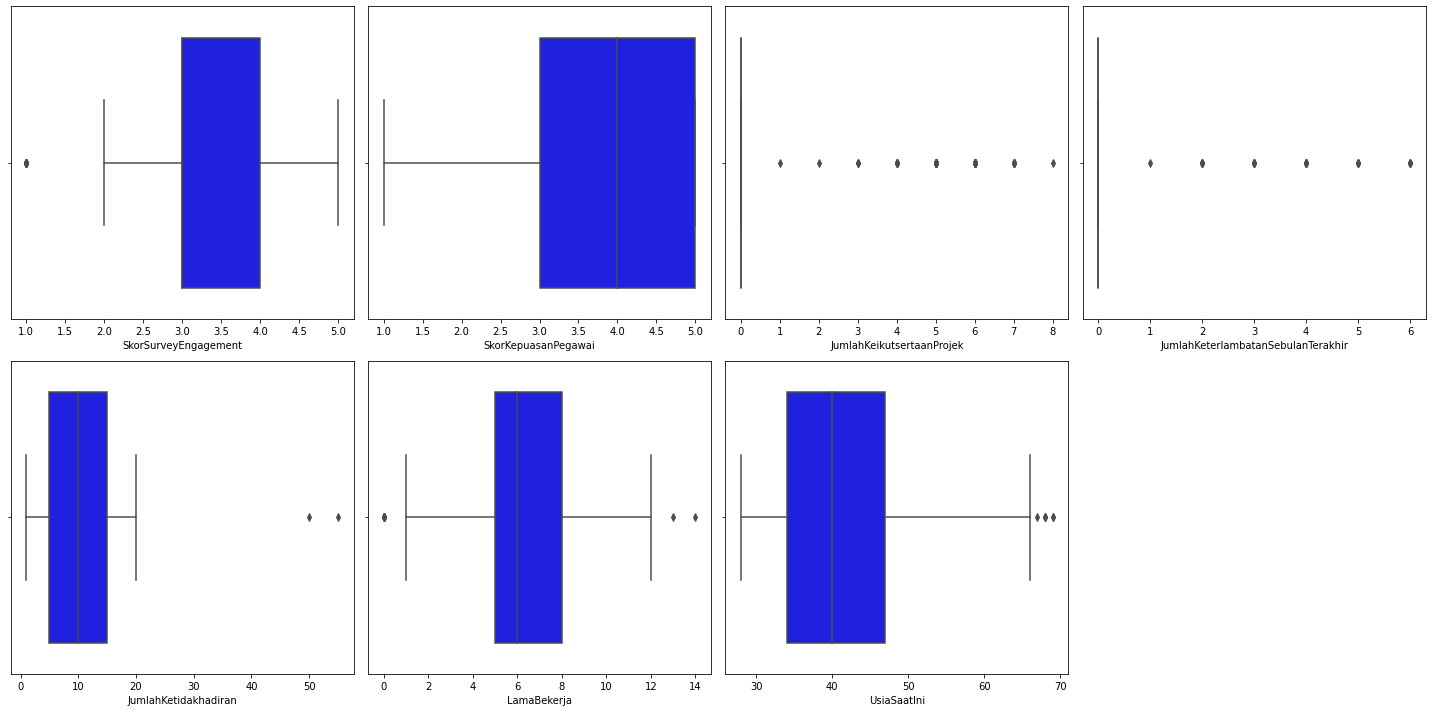

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(num_var)):
    plt.subplot(2, 4, i+1)
    sns.boxplot(df[num_var[i]], color='blue')
    plt.tight_layout()

**Analisa Output**
- Hampir semua kolom memiliki outliers

In [ ]:
def find_outliers(df):
  q1= df.quantile(0.25)
  q3= df.quantile(0.75)
  IQR = q3 - q1
  low_limit = q1 - (1.5 * IQR)
  high_limit = q3 + (1.5 * IQR)
  
  outliers = df[((df<(q1 - 1.5*IQR)) | 
                 (df>(q3 + 1.5*IQR))).any(axis=1)]

  return outliers

find_outliers(df[num_var])

,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,LamaBekerja,UsiaSaatIni
1,4,4,4,0,3,4.0,36
3,3,3,0,4,6,6.0,41
5,3,4,6,0,10,4.0,40
6,2,3,4,0,19,6.0,41
9,4,5,6,0,4,5.0,36
...,...,...,...,...,...,...,...
265,2,2,0,3,4,9.0,44
266,3,4,0,0,15,13.0,45
267,4,5,3,0,13,9.0,41
280,3,5,7,0,16,6.0,36


**Analisa Output**
- Terlihat data memiliki outliers hampir 30%, sehingga data tidak akan dihapus dan model yang akan digunakan adalah berbasis tree karena robust terhadap outliers

#### Kategorikal Feature

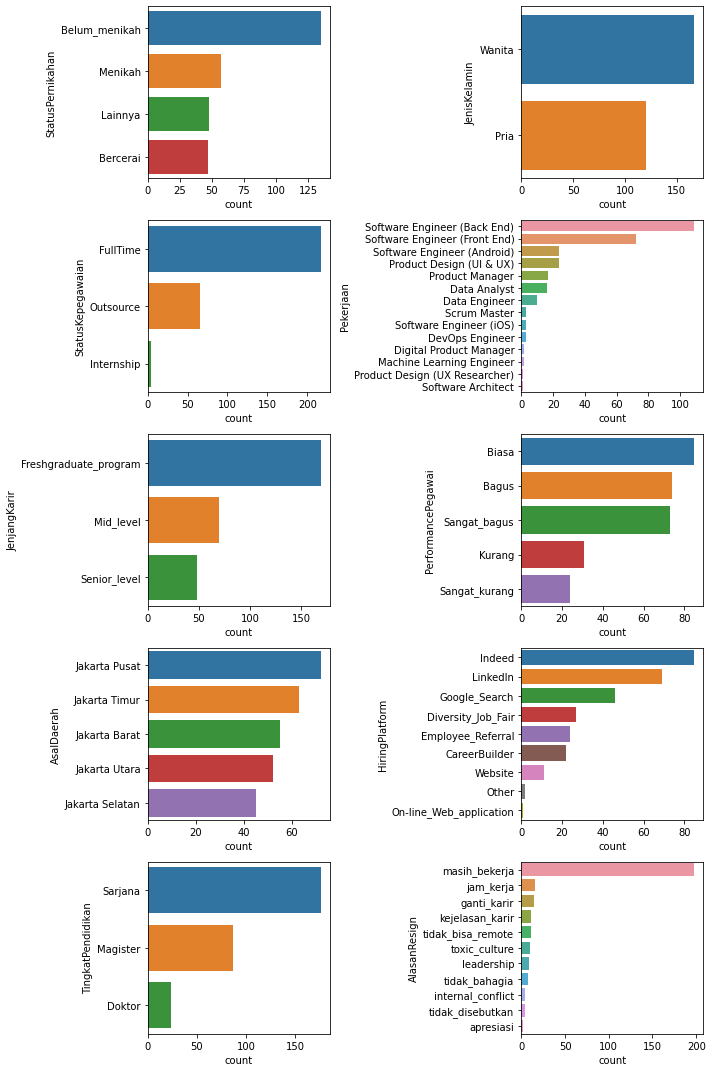

In [ ]:
plt.figure(figsize=(10, 15))
for i in range(0, len(cat_var)):
    plt.subplot(5, 2,i+1)
    sns.countplot(y=df[cat_var[i]], order=df[cat_var[i]].value_counts().index, orient='v')
    plt.tight_layout()

**Analisa Output**
- Mayoritas pegawai didominasi lajang
- pekerjaan dengan pegawai terbanyak adalah Backend dan Frontend
- untuk performa sendiri masih terbilang diandalkan
- AsalDaerah berasal dari provinsi DKI Jakarta
- Pegawai di hiring dari website online
- tingkat pendidikan di dominasi sarjana hal ini masuk akal dengan pegawai yang kebanyakan berasal dari freshgraduate
- untuk alasan resign sangat beragam

#### Target

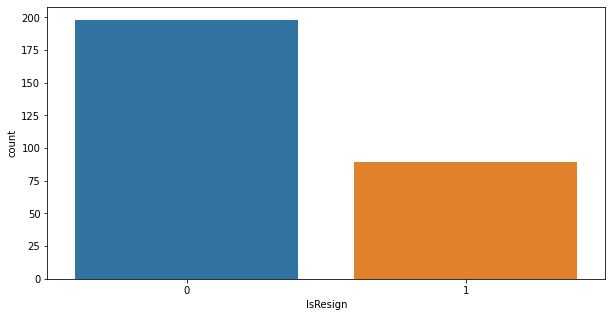

In [ ]:
plt.figure(figsize=(10,5))
sns.countplot(df['IsResign'])
plt.show()

**Analisa Output**
- Terlihat feature target datanya tidak seimbang sehingga termasuk ke dalam unbalanced data

### Bivariate Analysis

#### Numerikal - Target

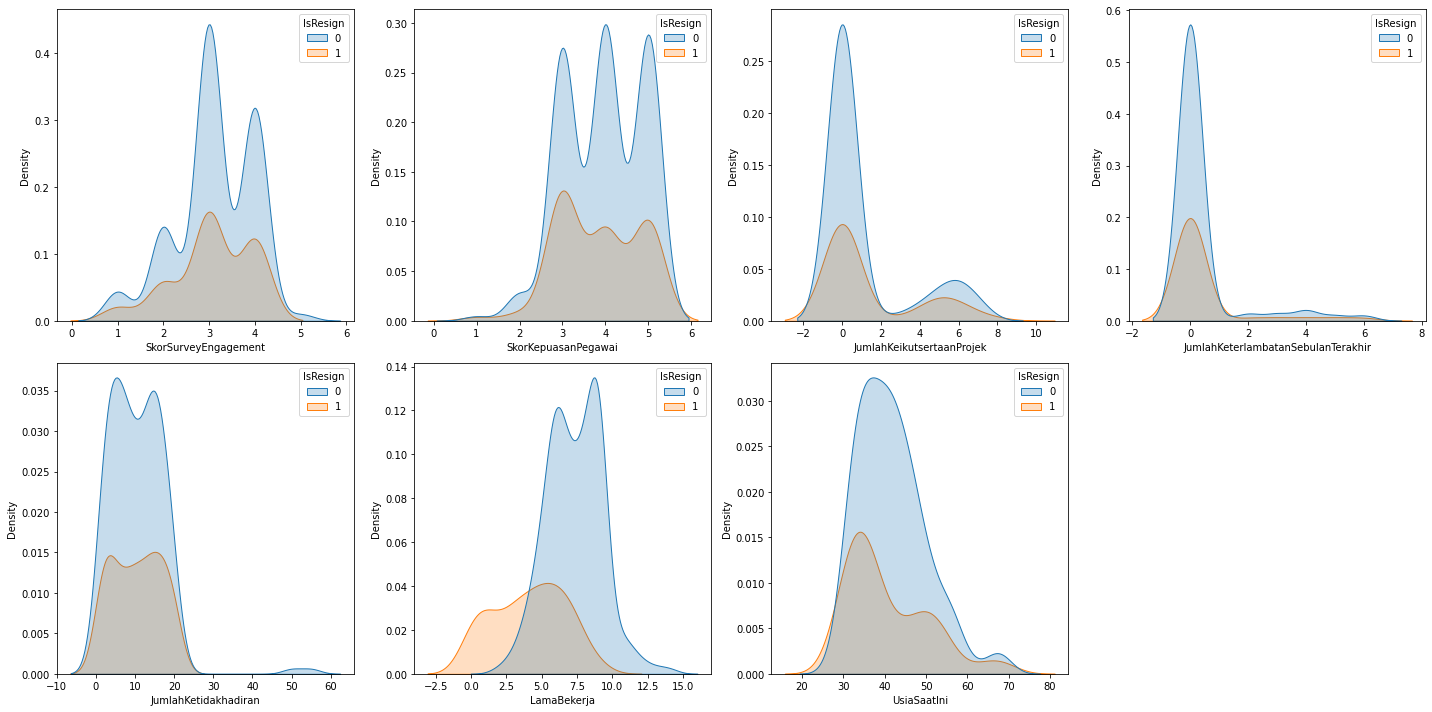

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(num_var)):
    plt.subplot(2, 4, i+1)
    sns.kdeplot(df[num_var[i]], color='blue', shade=True, hue=df['IsResign'])
    plt.tight_layout()

**Analisa Output**
- Yang menarik adalah lama bekerja terlihat bahwa dibawah 3 tahun cenderung resign

#### Kategorikal - Target

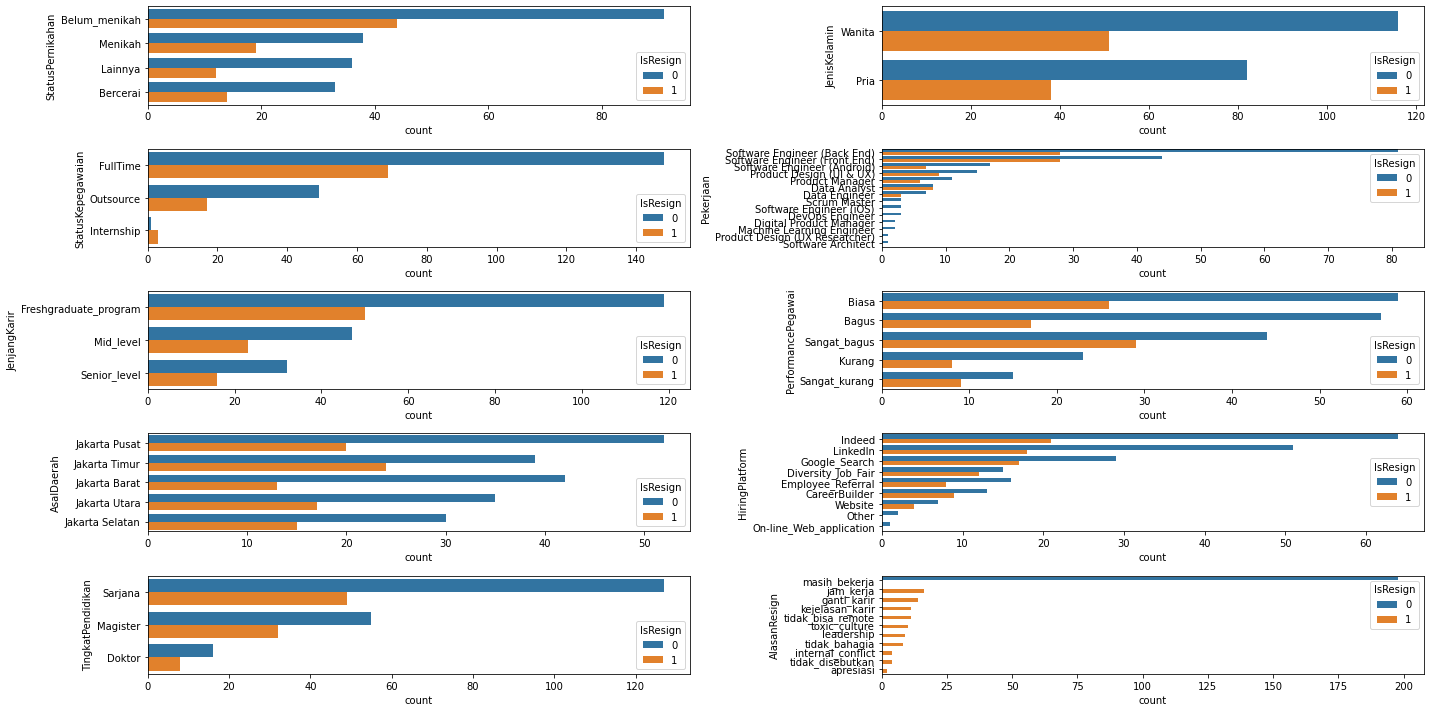

In [ ]:
plt.figure(figsize=(20, 10))
for i in range(0, len(cat_var)):
    plt.subplot(5, 2,i+1)
    sns.countplot(y=df[cat_var[i]], order=df[cat_var[i]].value_counts().index, orient='v', hue=df['IsResign'])
    plt.tight_layout()

**Analisa Output**
- Performa pegawai yang sangat bagus 40% mengundurkan diri

#### Numerikal - Numerikal

In [ ]:
nums_var = num_var.copy()
nums_var.append('IsResign')

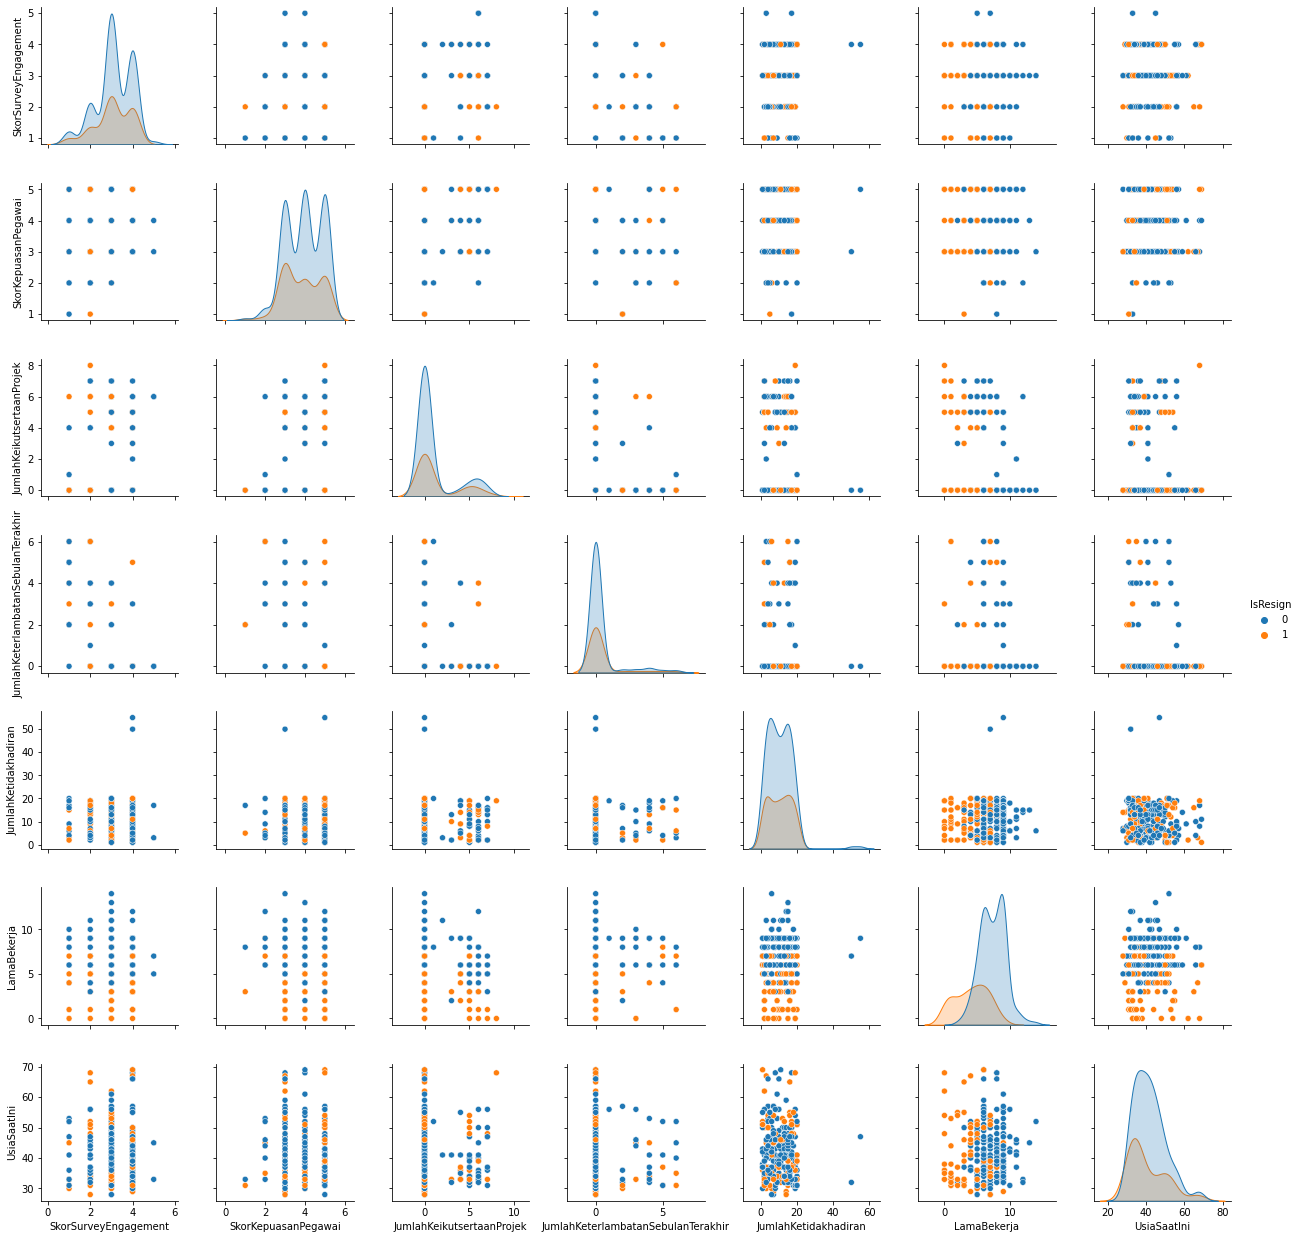

In [ ]:
sns.pairplot(df[nums_var], hue='IsResign')
plt.show()

**Analisa Output**
- Skor Engagement, Kepuasan, Jumlah Proyek, Keterlambatan, Ketidakhadirin, Usia memiliki korelasi dengan lama bekerja, Semakin sedikit lama bekerja, cenderung resign.

#### Numerikal - Kategorikal

In [ ]:
from sklearn.preprocessing import RobustScaler

In [ ]:
robust_scaler = RobustScaler()
scaled_data = robust_scaler.fit_transform(df[num_var])

In [ ]:
df_scaled = pd.DataFrame(scaled_data, columns = num_var)
df_scaled.head()

,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,LamaBekerja,UsiaSaatIni
0,1.0,0.0,0.0,0.0,-0.1,1.000000,0.615385
1,1.0,0.0,4.0,0.0,-0.7,-0.666667,-0.307692
2,1.0,-0.5,0.0,0.0,0.1,-1.000000,0.461538
3,0.0,-0.5,0.0,4.0,-0.4,0.000000,0.076923
4,0.0,-0.5,0.0,0.0,0.1,-0.333333,0.461538


In [ ]:
df_new = pd.concat([df_scaled, df.loc[:, "IsResign"]], axis = 1)
df_new.head()

,SkorSurveyEngagement,SkorKepuasanPegawai,JumlahKeikutsertaanProjek,JumlahKeterlambatanSebulanTerakhir,JumlahKetidakhadiran,LamaBekerja,UsiaSaatIni,IsResign
0,1.0,0.0,0.0,0.0,-0.1,1.000000,0.615385,0
1,1.0,0.0,4.0,0.0,-0.7,-0.666667,-0.307692,1
2,1.0,-0.5,0.0,0.0,0.1,-1.000000,0.461538,1
3,0.0,-0.5,0.0,4.0,-0.4,0.000000,0.076923,0
4,0.0,-0.5,0.0,0.0,0.1,-0.333333,0.461538,1


In [ ]:
for i in df[cat_var]:
    df_new = pd.concat([df_scaled, df.loc[:, i]], axis = 1)
    melted_data = pd.melt(df_new, id_vars = i, var_name = "variables", value_name = "value")
    
    plt.figure(figsize = (8, 5))
    sns.swarmplot(x = "variables", y = "value", hue = i, data = melted_data)
    
    plt.xlabel("variables")
    plt.ylabel("value")

    plt.legend(bbox_to_anchor=(1.04, 1), loc="upper left")
    
    plt.tight_layout()
    plt.show()

**Analisa Output**
- Terlihat tidak ada hubungan yang menarik

### Multivariate Analysis

In [ ]:
df[nums_var].corr()

In [ ]:
plt.figure(figsize = (15, 10))
sns.heatmap(data = df[nums_var].corr(method='pearson'), cmap = "Spectral", annot = True, linewidths = 0.5)
plt.tight_layout()
plt.show()

**Analisa Output**
- Kolom yang memiliki korelasi dengan target adalah lama bekerja, dengan korelasi negatif moderate
- Jumlah keterlambatan memiliki korelasi dengan skor engagement dengan negatif moderate

## Data Preparation

### Feature Selection

Adapun Teknik Feature Selection antara lain:
- Feature yang bertipe datetime dan memiliki banyak nilai null tidak dipakai
- Melalui pendekatan Human Centered AI dengan menghapus feature yang sekiranya mengandung diskriminatif

In [ ]:
print(num_var)
print(cat_var)

Feature StatusPernikahan, JenisKelamin, AsalDaerah, HiringPlatform, TingkatPendidikan, AlasanResign, Pekerjaan perlu di drop untuk menghindari diskriminatif

In [ ]:
cat_use = ['StatusKepegawaian','JenjangKarir','PerformancePegawai']

feature = []
feature.extend(num_var)
feature.extend(cat_use)
feature.append('IsResign')

#### Split Data

Pemisahan data Training dan data Testing dengan rasio 70:30 dan rasio target sama

In [ ]:
X = df[feature].drop('IsResign', axis=1)
y = df['IsResign']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

In [ ]:
print(y_train.value_counts(normalize=True))
print(y_test.value_counts(normalize=True))

### Pipeline

- Feature Encoding
  - Kolom kategorikal yang terdapat di dataset ini terdiri dari nominal dan ordinal, untuk nominal dilakukan one hot, sedangkan ordinal dilakukan dengan ordinalencoding
  - Kolom Ordinal adalah JenjangKarir dan PerformancePegawai
  - Untuk Nominal adalah Status kepegawaian dilakukan onehot

- Feature Transform
  - Karena kolom tidak berdistribusi normal maka dilakukan standarisasi


In [ ]:
for x in cat_use:
  print(df[x].value_counts())

In [ ]:
#create pipeline

karir_levels = ['Freshgraduate_program', 'Mid_level', 'Senior_level']
performance_levels = ['Sangat_kurang', 'Kurang', 'Biasa','Bagus','Sangat_bagus']

num_pip = Pipeline([
    ('scaler', StandardScaler())
])

nominal_pip = Pipeline([
    ('onehot', OneHotEncoder())
])

ordinal_karir = Pipeline([
    ('ordinal1', OrdinalEncoder(categories=[karir_levels], dtype=int))
])

ordinal_performance = Pipeline([
    ('ordinal2', OrdinalEncoder(categories=[performance_levels], dtype=int))
])

preprocessor = ColumnTransformer([
    ('numeric', num_pip, num_var),
    ('nominal', nominal_pip, ['StatusKepegawaian']),
    ('ordinal_karir', ordinal_karir, ['JenjangKarir']),
    ('ordinal_performance', ordinal_performance, ['PerformancePegawai'])
])

In [ ]:
preprocessor.fit(X_train)
train_X = preprocessor.transform(X_train)
test_X =preprocessor.transform(X_test)

In [ ]:
pd.DataFrame(train_X)

In [ ]:
for i,j in enumerate(feature):
  print(i, j, df[j].nunique())

Keterangan:
- Feature 0-6 Adalah Numerikal
- 7-9 adalah Status Kepegawaian
- 10 adalah JenjangKarir
- 11 adalah performance pegawai

## Data Modelling

### First Modelling

- Handling Imbalanced 
  - Untuk mengatasi imbalanced data, akan menggunakan parameter class weight dan sejenisnya pada masing2 model
  - decision tree, random_forest, lgbm mempunyai parameter class_weight
  - xgboost mempunyai scale_pos_weight
  - Gradient Boosting deals with class imbalance

In [ ]:
tot_0 = len(y_train) - y_train.sum()
tot_1 = y_train.sum()

spw = tot_1/tot_0

In [ ]:
dtree = DecisionTreeClassifier(class_weight='balanced',random_state=42)
rf = RandomForestClassifier(class_weight='balanced',random_state=42)
grad = GradientBoostingClassifier()
xgb = XGBClassifier(scale_pos_weight=spw,random_state=42)
LGBM = lgb.LGBMClassifier(class_weight='balanced',random_state=42)
LR = LogisticRegression(class_weight="balanced")

In [ ]:
def eval_classification(model, X_train, y_train, X_test, y_test):
  model.fit(X_train, y_train)
  y_pred_train = model.predict(X_train)
  y_pred = model.predict(X_test)
  y_pred_proba = model.predict_proba(X_test)
  y_pred_proba_train = model.predict_proba(X_train)
  accuracy = accuracy_score(y_test,y_pred)
  accuracy_train = accuracy_score(y_train,y_pred_train)
  recall = recall_score(y_test,y_pred)
  precision = precision_score(y_test,y_pred)
  f1 = f1_score(y_test,y_pred)
  AUC_test = roc_auc_score(y_test, y_pred_proba[:, 1])
  AUC_train = roc_auc_score(y_train, y_pred_proba_train[:, 1])
  score = cross_validate(model, X_train, y_train, cv=3, scoring='roc_auc', return_train_score=True)
  auc_train_cv = score['train_score'].mean()
  auc_test_cv = score['test_score'].mean()

  result = {
      'Model' : str(model),
      'Akurasi_Train' : accuracy_train,
      'Akurasi_Test' : accuracy,
      'Presisi' : precision,
      'Recall' : recall,
      'F1' : f1,
      'roc_auc_train' : AUC_train,
      'roc_auc_test' : AUC_test,
      'roc_auc_train_cv': auc_train_cv,
      'roc_auc_test_cv': auc_test_cv
      }

  return result

In [ ]:
models = [dtree, LR, rf, grad, xgb, LGBM]

list_models = []

for model in models:
  list_models.append(eval_classification(model, train_X, y_train, test_X, y_test))

pd.DataFrame(list_models)

### Hyperparameter Tuning

In [ ]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

# penalty = ['l1', 'l2']
# C = [float(x) for x in np.linspace(0.0001, 0.05, 100)]
# solver = ['sag', 'saga', 'lbfgs']
# hyperparameters = dict(penalty=penalty, C=C, solver=solver)

# rs = RandomizedSearchCV(LR, hyperparameters, scoring='roc_auc', random_state=42, cv=5)
# pd.DataFrame(eval_classification(rs, train_X, y_train, test_X, y_test), index=[0])





# #Menjadikan ke dalam bentuk dictionary
# hyperparameters = {
#                     'max_depth' : [int(x) for x in np.linspace(10, 110, num = 11)],
#                     'min_child_weight' : [int(x) for x in np.linspace(1, 20, num = 11)],
#                     'gamma' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'tree_method' : ['auto', 'exact', 'approx', 'hist'],

#                     'colsample_bytree' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'eta' : [float(x) for x in np.linspace(0, 1, num = 100)],

#                     'lambda' : [float(x) for x in np.linspace(0, 1, num = 11)],
#                     'alpha' : [float(x) for x in np.linspace(0, 1, num = 11)]
#                     }

# # Init
# xg_tuned = RandomizedSearchCV(xgb, hyperparameters, cv=5, random_state=42, scoring='recall')
# pd.DataFrame(eval_classification(xg_tuned, train_X, y_train, test_X, y_test), index=[0])


# List of hyperparameter
max_depth = [int(x) for x in np.linspace(1, 110, num = 30)] # Maximum number of levels in tree
min_samples_split = [2, 5, 10, 100] # Minimum number of samples required to split a node
min_samples_leaf = [1, 2, 4, 10, 20, 50] # Minimum number of samples required at each leaf node
max_features = ['auto', 'sqrt'] # Number of features to consider at every split
criterion = ['gini','entropy']
splitter = ['best','random']

hyperparameters = dict(max_depth=max_depth, 
                       min_samples_split=min_samples_split, 
                       min_samples_leaf=min_samples_leaf,
                       max_features=max_features,
                       criterion=criterion,
                       splitter=splitter
                      )

# Inisialisasi Model
dtree_tuning = GridSearchCV(dtree, hyperparameters, cv=5, scoring='roc_auc')
pd.DataFrame(eval_classification(dtree_tuning, train_X, y_train, test_X, y_test), index=[0])

In [ ]:
dtree_tuning.best_params_

In [ ]:
# LR_tuning = LogisticRegression(class_weight="balanced", penalty = 'l1', C = 0.04747979797979799, solver='saga')

# xgb_tuning = XGBClassifier(scale_pos_weight=spw,
#                            random_state=42, 
#                            tree_method = 'hist',
#                            min_child_weight = 2,
#                            max_depth = 110,
#                            reg_lambda = 0.2,
#                            gamma = 0.5,
#                            eta = 0.7777777777777778,
#                            colsample_bytree = 1.0,
#                            alpha = 0.1
#                            )

dt_tuning = DecisionTreeClassifier(
    class_weight='balanced',
    random_state=42, 
    criterion = 'gini',
    max_depth = 8,
    max_features = 'auto',
    min_samples_leaf = 4,
    min_samples_split= 2,
    splitter = 'best'
    )

In [ ]:
# pd.DataFrame(eval_classification(LR_tuning, train_X, y_train, test_X, y_test), index=[0])
# pd.DataFrame(eval_classification(xgb_tuning, train_X, y_train, test_X, y_test), index=[0])

pd.DataFrame(eval_classification(dt_tuning, train_X, y_train, test_X, y_test), index=[0])

### Tuning Threshold

In [ ]:
# final_prediction = LR_tuning.predict_proba(test_X)[:,1]
# final_prediction = xgb_tuning.predict_proba(test_X)[:,1]
final_prediction = dt_tuning.predict_proba(test_X)[:,1]
final_prediction

In [ ]:
print('test roc-auc:', roc_auc_score(y_test,final_prediction))

In [ ]:
fpr, tpr, thresholds_list = roc_curve(y_test, final_prediction)
thresholds_list

In [ ]:
roc_auc_ls = []
for threshold in thresholds_list:
    y_pred = np.where(final_prediction_1 > threshold,1,0)
    roc_auc_ls.append(roc_auc_score(y_test, y_pred))
    
roc_auc_ls = pd.concat([pd.Series(thresholds_list), pd.Series(roc_auc_ls)],
                        axis=1)
roc_auc_ls.columns = ['thresholds_list', 'roc_auc']
roc_auc_ls.sort_values(by='roc_auc', ascending=False, inplace=True)
roc_auc_ls.head()

In [ ]:
roc_auc_ls[roc_auc_ls['roc_auc'] >= 0.7]

In [ ]:
def plot_roc_curve(fpr, tpr):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.legend()
    plt.show()

In [ ]:
plot_roc_curve(fpr,tpr)

### Save Model

In [ ]:
# save model
algo = Pipeline([
    ('preprocess', preprocessor),
    ('algo', dt_tuning)
    ])
algo.fit(X_train, y_train)

### Confusion Matrix

In [ ]:
thresholds = 0.597403 	 # 0.618711 
y_pred_thrs = algo.predict_proba(X_test)[:,1] >= thresholds
y_pred = algo.predict(X_test)

print('akurasi :', accuracy_score (y_test, y_pred_thrs))
print('precision :', precision_score (y_test, y_pred_thrs))
print('recall :', recall_score (y_test, y_pred_thrs))
print('F1 score :', f1_score (y_test, y_pred_thrs))
print('ROC AUC :', roc_auc_score (y_test, y_pred_thrs))

In [ ]:
cnf_matrix=confusion_matrix(y_test,y_pred)
print(classification_report(y_test,y_pred))

In [ ]:
plt.figure(figsize=(4,4))
sns.heatmap(cnf_matrix,cmap='Greens',annot=True,linewidth=0.5,fmt='d')
plt.title('Confusion Matrix')
plt.xlabel('Prediksi')
plt.ylabel('Aktual')
plt.show()

### Feature Importance

In [ ]:
def show_feature_importance(model):
    feat_importances = pd.Series(model.feature_importances_)
    ax = feat_importances.nlargest(25).plot(kind='barh', figsize=(10, 8))
    ax.invert_yaxis()

    plt.xlabel('score')
    plt.ylabel('feature')
    plt.title('feature importance score')

In [ ]:
show_feature_importance(algo['algo'])

**Analisa Output**
- Adapun feature yang mempengaruhi adalah
  - 5 = Lama Bekerja
  - 6 = UsiaSaatIni
  - 4 = JumlahKetidakhadiran
  - 1 = SkorKepuasanPegawai
  - 11 = PerformancePegawai
  - 2 = JumlahKeikutsertaanProjek

In [ ]:
import shap

explainer = shap.TreeExplainer(dt_tuning)
shap_values = explainer.shap_values(test_X)
shap.summary_plot(shap_values, test_X)

In [ ]:
shap.summary_plot(shap_values[1], test_X)

In [ ]:
df